## Convolutional Neural Networks for CIFAR-10 multiclass image classification
In this study, we compare different optimizers and investigate Cyclical Learning Rate scheduling method for classification of images in CIFAR-10 dataset. LR (Learning Rate) range test is employed to estimate the upper and lower bounds of learning rate scheduling. We also explore deeper architectures to increase classification accuracy. Image augmentation, Batch Normalization and Dropout methods are implemented to reduce overfitting observed with deeper neural networks.

In [171]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torch.nn.init import xavier_uniform_
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [79]:
#define functions to split train set into train and validation sets and generate train, validation & test dataloaders
def get_train_valid_loader(batch_size,
                           augment,
                           data_dir = './data',
                           random_seed=42,
                           valid_size=0.2,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. 

    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.

    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process
    test iterator over the CIFAR-10 dataset.

    If using CUDA, num_workers should be set to 1 and pin_memory to True.

    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.

    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return data_loader

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [81]:
#define function to calculate accuracy by comparing predictions obtained by feed forward method and labels
def get_accuracy(output, labels):
    """
    Return the accuracy of the model on the input data and actual ground truth.
    """
    
    _,predicted = torch.max(output.data,1)
    total = labels.size(0)
    correct = (predicted == labels).sum()
    accuracy = torch.true_divide(100*correct, total)
    return accuracy

In [82]:
#define function to plot loss and accuracy curves for train and validation sets
def plot_curves(train_accuracies,train_losses,validation_accuracies,validation_losses, ax=None):
    
    plt.figure(figsize=(8,6))
    if ax is None:
        ax=plt.gca()
        
    # Plot the results (shifting validation curves appropriately)
    color = 'tab:red'
    ax.set_xlabel('Number of epochs', fontsize=12)
    ax.set_ylabel('Accuracy', color=color, fontsize=12)
    n = len(train_accuracies)
    ax.plot(np.arange(0,n),train_accuracies, color='orange', label='Train accuracy')
    ax.plot(np.arange(0,n),validation_accuracies,'r', label='Val accuracy')
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_ylim(0,105)
    ax.legend(frameon=False)
    ax.grid(True)
    ax2 = ax.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('loss', color=color, fontsize=12)
    ax2.plot(np.arange(0,n),train_losses,'b', label='Train loss')
    ax2.plot(np.arange(0,n),validation_losses,'g', label='Val loss')
    ax2.legend(frameon=False, loc='upper center')
    ax2.set_ylim(0,2.5)
    return ax

In [83]:
#create train and validation dataloaders
trainloader,validloader = get_train_valid_loader(batch_size=50,
                           augment=False,
                           data_dir = './data',
                           random_seed=42,
                           valid_size=0.2,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
dataloaders = {'train':trainloader, 'validation': validloader}

In [227]:
#create test dataloader
testloader = get_test_loader(data_dir = './data',
                    batch_size=50,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False)

Files already downloaded and verified


In [85]:
#create class for CNN1 network architecture
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            #nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
          
        
        self.fc_layers = nn.Sequential(
            nn.Linear(400,120),
            #nn.Dropout(0.1),
            nn.Linear(120,84),
            #nn.Dropout(0.1),
            nn.Linear(84,10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out


In [86]:
#loss function
criterion = nn.CrossEntropyLoss()

In [87]:
#define function to train model on train set and evaluate on validation set. 
def train_model(model, optimizer_key, n_epochs, plot_history=True,print_stats=True):
    """Trains model on train set and evaluates on validation set.
    Params:
    1. model - CNN architecture
    2. optimizer_key: optimizer
    3.n_epochs: number of epochs
    4.plot_history: if true, plots loss and accuracy curves for train and validation sets
    print_stats: of true, prints average loss and accuracy for train and validation sets after every 100 minibatches
    
    Returns:
    list of average train and validation accuracies after every epoch

"""
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    model = model.to(device)
    if optimizer_key == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_key == 'Adam':
        optimizer = optim.Adam(model.parameters())    
    elif optimizer_key == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters())
    elif optimizer_key == 'Adamax':
        optimizer = optim.Adamax(model.parameters())
    elif optimizer_key == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters())
        
        
    for epoch in range(n_epochs):
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_accuracy = 0.0
            epoch_loss = 0.0
            epoch_accuracy = 0.0
        
            # Iterate over data.
            for i, (inputs,labels) in enumerate(dataloaders[phase]):

            
                # forward pass to get outputs
                output = model(inputs)

                # calculate the loss between predicted and target keypoints
                loss = criterion(output, labels)
                
                
                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()
                
                accuracy = get_accuracy(output,labels)    
                running_loss += loss.item()
                epoch_loss += loss.item()
                running_accuracy += accuracy.item()
                epoch_accuracy += accuracy.item()
            
                
                if print_stats:
                    if i % 100 == 99:    # print every 100 mini-batches
                        print('[%d, %5d] %s loss: %.3f' %(epoch + 1, i + 1, phase,running_loss / 100),
                             ', accuracy: %.1f' %(running_accuracy / 100) +'%')
                        running_loss = 0.0
                        running_accuracy = 0.0
                
                
            if phase == 'train':
                train_losses.append(epoch_loss/len(dataloaders[phase]))
                train_accuracies.append(epoch_accuracy/len(dataloaders[phase]))
            else:
                validation_losses.append(epoch_loss/len(dataloaders[phase]))
                validation_accuracies.append(epoch_accuracy/len(dataloaders[phase]))
                
    # plot curves
    if plot_history:
        plot_curves(train_accuracies,train_losses,validation_accuracies,validation_losses, ax=None)
    return train_accuracies,validation_accuracies



In [88]:
#train model using CNN1, with default learning rate for each optimizer for 25 epochs 
default_performances = []
for key in ["SGD","Adam","Adagrad","Adamax","Adadelta"]:
    print('testing {}:' .format(key))
    performance = train_model(model=Model1(), optimizer_key=key, n_epochs=25, plot_history=False,print_stats=False)
    default_performances.append(performance)
    

testing SGD:
testing Adam:
testing Adagrad:
testing Adamax:
testing Adadelta:


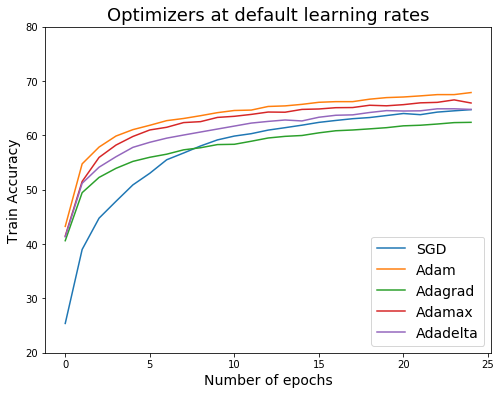

In [282]:
#compare accuracies of optimizers at default learning rate
optimizers_list = ['SGD','Adam','Adagrad','Adamax','Adadelta']
plt.figure(figsize=(8,6))
for i in range(len(default_performances)):
    n = len(default_performances[i][0])
    plt.plot(np.arange(0,n),default_performances[i][0], label = optimizers_list[i])
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Train Accuracy',fontsize=14)
    plt.ylim(20,80)
    plt.legend(fontsize=14)
    plt.title('Optimizers at default learning rates', fontsize=18)

In [242]:
#define function to conduct LR range test

def lr_range_finder(model,optimizer_key,start_lr,end_lr, lr_find_epochs, ax=None):
    """Create lr-loss plot to determine upper bound of cyclical learning rate schedule using LR range test.
    params
    1. model: CNN architecture to use for running the test
    2. optimizer_key: optimizer
    3. start_lr: base learning rate
    4. end_lr: maximim learning rate
    5. lr_find_epochs: number of epochs 
    6. ax: if specified, plot lr-loss curve on the axes, else create new figure
    """
    model = model.to(device)
    if optimizer_key == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=start_lr)
    elif optimizer_key == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=start_lr)    
    elif optimizer_key == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=start_lr)
    elif optimizer_key == 'Adamax':
        optimizer = optim.Adamax(model.parameters(), lr=start_lr)
    elif optimizer_key == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(), lr=start_lr)


    #LR function lambda
    lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( dataloaders["train"])))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    # Run the experiment 

    lr_find_loss = []
    lr_find_lr = []

    iter = 0

    smoothing = 0.05

    for i in range(lr_find_epochs):
        
        for inputs, labels in dataloaders["train"]:
    
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # Training mode and zero gradients
            model.train()
            optimizer.zero_grad()
    
            # Get outputs to calc loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update LR
            scheduler.step()
            lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
            lr_find_lr.append(lr_step)

            # smooth the loss
            if iter==0:
                lr_find_loss.append(loss)
            else:
                loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
                lr_find_loss.append(loss)
     
        iter += 1
        
        lr = np.asarray(lr_find_lr)
        losses = np.asarray(lr_find_loss).astype('float')
        
        plt.figure(figsize=(8,6))
        if ax is None:
            ax=plt.gca()
            
        ax.plot(lr,losses)
        ax.set_xscale('log')
        ax.set_xlabel('Learning rate (log)', fontsize = 14)
        ax.set_ylabel('loss', fontsize=14)
        ax.minorticks_on()
        ax.tick_params(which='major', length=10, width=2, direction='inout', labelsize=14)
        ax.tick_params(which='minor', length=5, width=2, direction='in', labelsize=14)
        ax.grid(which='both')
        
        
            
        
    

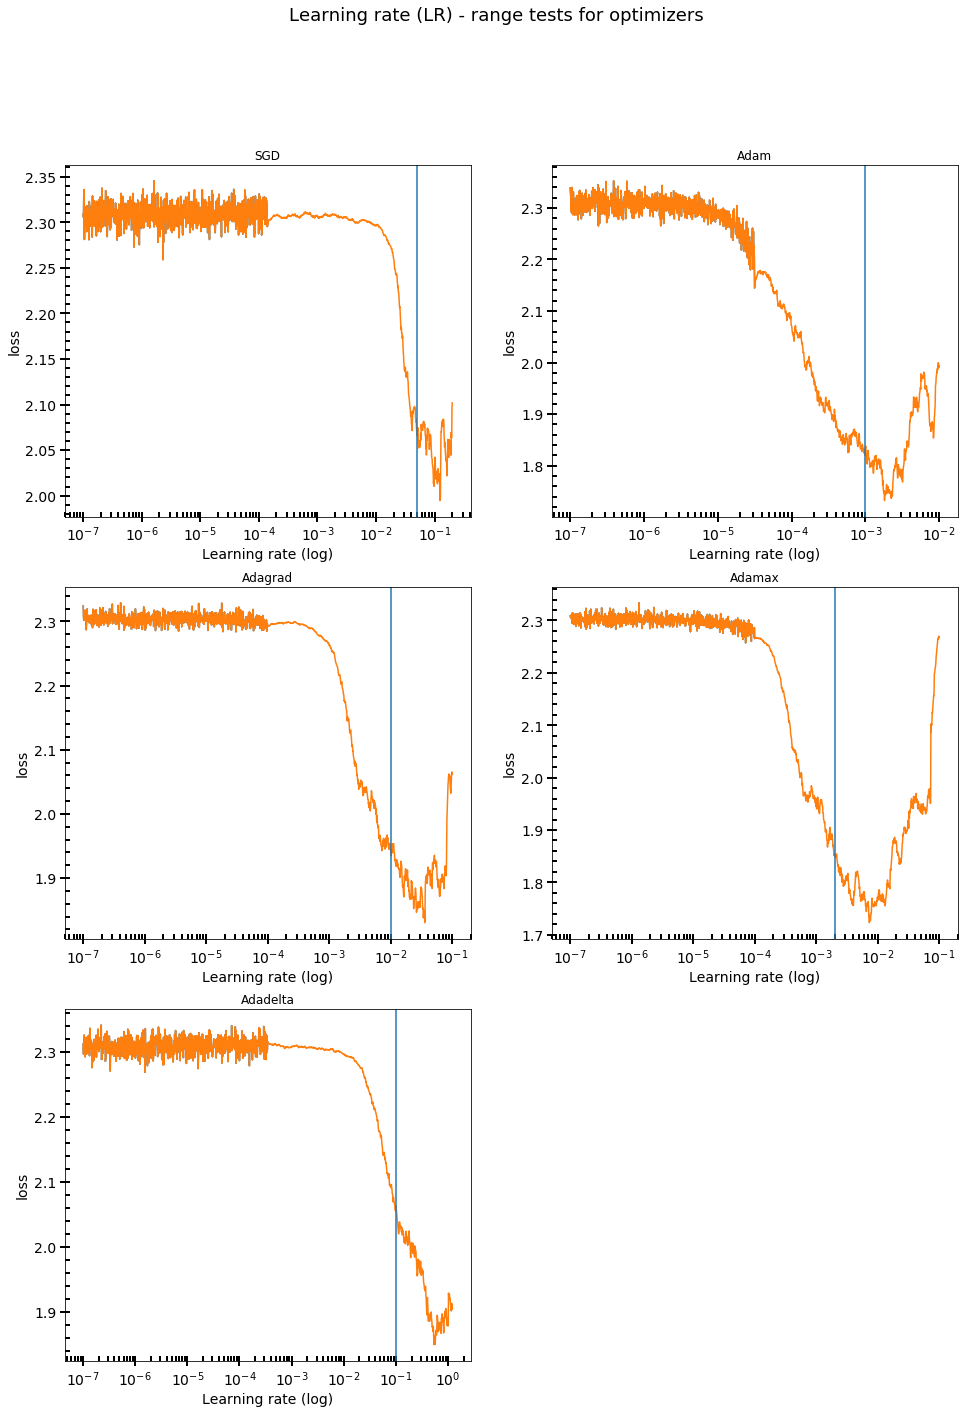

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [244]:
#conduct lr-range test using CNN1 for each optimizer and plot lr-loss curves
fig,axes = plt.subplots(3,2, figsize = (16,22))
fig.suptitle('Learning rate (LR) - range tests for optimizers', fontsize = 18)
axes[2,1].axis('off')
lr_range_finder(Model1(),'SGD',start_lr=1e-7,end_lr=0.2, lr_find_epochs=2, ax=axes[0,0])
axes[0,0].set_title('SGD')
axes[0,0].axvline(x=5e-2)
lr_range_finder(Model1(),'Adam',start_lr=1e-7,end_lr=1e-2, lr_find_epochs=2, ax=axes[0,1])
axes[0,1].set_title('Adam')
axes[0,1].axvline(x=1e-3)
lr_range_finder(Model1(),'Adagrad',start_lr=1e-7,end_lr=1e-1, lr_find_epochs=2, ax=axes[1,0])
axes[1,0].set_title('Adagrad')
axes[1,0].axvline(x=1e-2)
lr_range_finder(Model1(),'Adamax',start_lr=1e-7,end_lr=1e-1, lr_find_epochs=2, ax=axes[1,1])
axes[1,1].set_title('Adamax')
axes[1,1].axvline(x=2e-3)
lr_range_finder(Model1(),'Adadelta',start_lr=1e-7,end_lr=1.2, lr_find_epochs=2, ax=axes[2,0])
axes[2,0].set_title('Adadelta')
axes[2,0].axvline(x=1e-1)
plt.tight_layout();


In [93]:
#define function to create cyclical learning rate bsed scheduler
def cyclical_lr(stepsize, min_lr=2e-3, max_lr=2e-2):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [152]:
#define function to train model on train set with cyclic learning rate scheduling method, evaluate on validation model
def train_model_lrs(model, optimizer_key, n_epochs,lr_max,path, plot_history=True,print_stats=True):
    """
    Train model on train set with cyclic learning rate scheduling method, evaluate on validation model.
    
    Params:
    1. model - CNN architecture
    2. optimizer_key: optimizer
    3.n_epochs: number of epochs
    4.lr_max: upper bound determined using lr-range test
    5.path: path to save parameters of trained model
    6.plot_history: if true, plots loss and accuracy curves for train and validation sets
    7. print_stats: of true, prints average loss and accuracy for train and validation sets after every 100 minibatches
    
    Returns:
    lists of average train and validation accuracies after every epoch


    """
    
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    
    model = model.to(device)
    if optimizer_key == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=1.)
    elif optimizer_key == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=1.)    
    elif optimizer_key == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=1.)
    elif optimizer_key == 'Adamax':
        optimizer = optim.Adamax(model.parameters(), lr=1.)
    elif optimizer_key == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(), lr=1.)
        
    factor = 6
    end_lr = lr_max
    step_size = 4*len(trainloader)
    clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])


    
    for epoch in range(n_epochs):
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_accuracy = 0.0
            epoch_loss = 0.0
            epoch_accuracy = 0.0
        
            # Iterate over data.
            for i, (inputs,labels) in enumerate(dataloaders[phase]):

            
                # forward pass to get outputs
                output = model(inputs)

                # calculate the loss between predicted and target keypoints
                loss = criterion(output, labels)
                
                
                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    
                    # Clip the gradients norm to avoid them becoming too large
                    clip_grad_norm_(model.parameters(), 5)
                    
                    # update the weights
                    optimizer.step()
                    
                    # Update the LR
                    scheduler.step()
                    lr_sched_test = scheduler.get_last_lr()
                
                accuracy = get_accuracy(output,labels)    
                running_loss += loss.item()
                epoch_loss += loss.item()
                running_accuracy += accuracy.item()
                epoch_accuracy += accuracy.item()
            
                
                if print_stats:
                    if i % 100 == 99:    # print every 100 mini-batches
                        print('[%d, %5d] %s loss: %.3f' %(epoch + 1, i + 1, phase,running_loss / 100),
                             ', accuracy: %.1f' %(running_accuracy / 100) +'%')
                        running_loss = 0.0
                        running_accuracy = 0.0
                
                
            if phase == 'train':
                train_losses.append(epoch_loss/len(dataloaders[phase]))
                train_accuracies.append(epoch_accuracy/len(dataloaders[phase]))
            else:
                validation_losses.append(epoch_loss/len(dataloaders[phase]))
                validation_accuracies.append(epoch_accuracy/len(dataloaders[phase]))
                
    # plot curves
    if plot_history:
        plot_curves(train_accuracies,train_losses,validation_accuracies,validation_losses, ax=None)
    
    
    torch.save(model.state_dict(), path)

    
    return train_accuracies,validation_accuracies



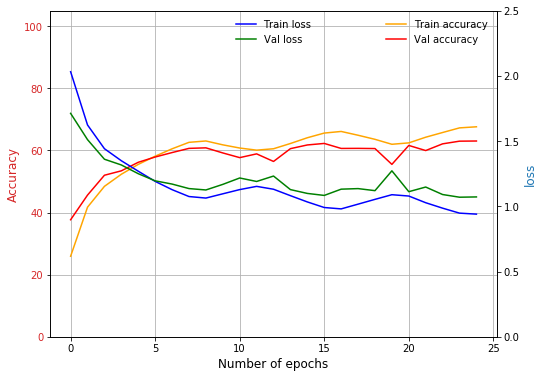

In [95]:
#Train model using CNN1, SGD optimizer with CLR method, for 25 epochs
sgd_lrs = train_model_lrs(Model1(), 'SGD', n_epochs=25,lr_max=5e-2, plot_history=True,print_stats=False)

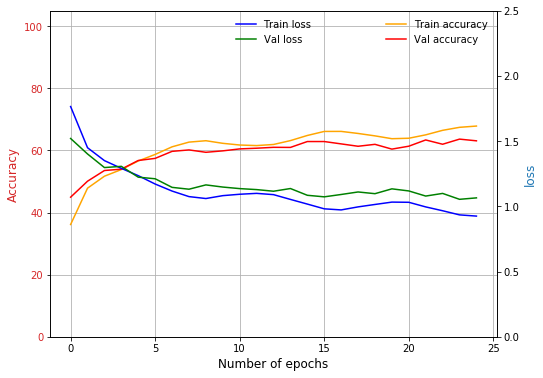

In [103]:
#Train model using CNN1, Adam optimizer with CLR method, for 25 epochs
adam_lrs = train_model_lrs(Model1(), 'Adam', n_epochs=25,lr_max=1e-3, plot_history=True,print_stats=False)

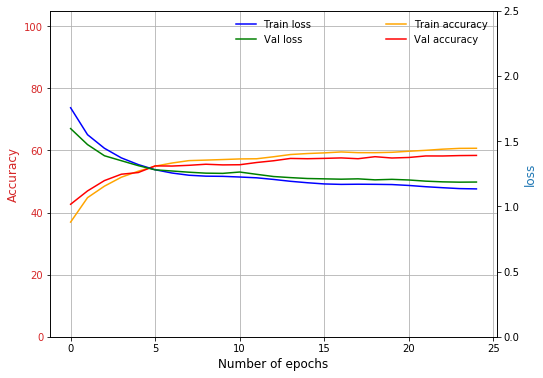

In [104]:
#Train model using CNN1, Adagrad optimizer with CLR method, for 25 epochs
adagrad_lrs = train_model_lrs(Model1(), 'Adagrad', n_epochs=25,lr_max=1e-2, plot_history=True,print_stats=False)

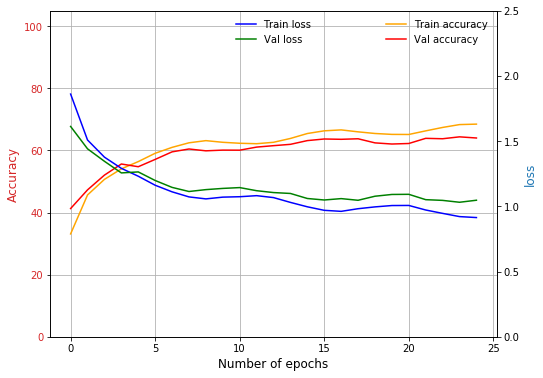

In [105]:
##Train model using CNN1, Adamax optimizer with CLR method, for 25 epochs
adamax_lrs = train_model_lrs(Model1(), 'Adamax', n_epochs=25,lr_max=2e-3, plot_history=True,print_stats=False)

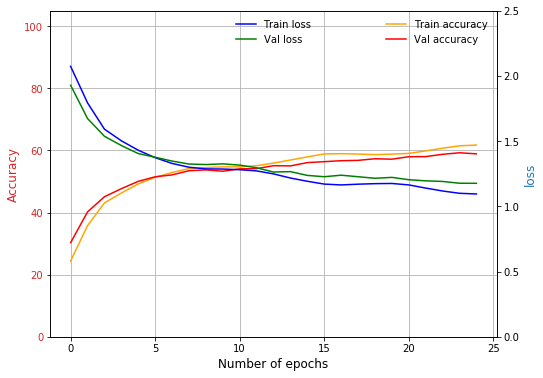

In [106]:
#Train model using CNN1, Adadelta optimizer with CLR method, for 25 epochs
adadelta_lrs = train_model_lrs(Model1(), 'Adadelta', n_epochs=25,lr_max=1e-1, plot_history=True,print_stats=False)

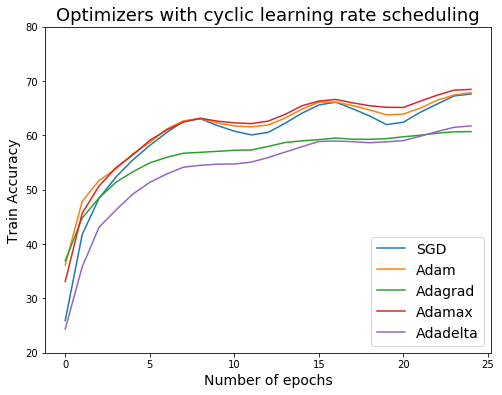

In [283]:
#compare accuracies of optimizers with cyclic learning rates
optimizers_names = ['SGD','Adam','Adagrad','Adamax','Adadelta']
plt.figure(figsize=(8,6))
for i in range(len(lrs_performances)):
    n = len(lrs_performances[i])
    plt.plot(np.arange(0,n),lrs_performances[i], label = optimizers_names[i])
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Train Accuracy',fontsize=14)
    plt.ylim(20,80)
    plt.legend(fontsize=14)
    plt.title('Optimizers with cyclic learning rate scheduling', fontsize=18)

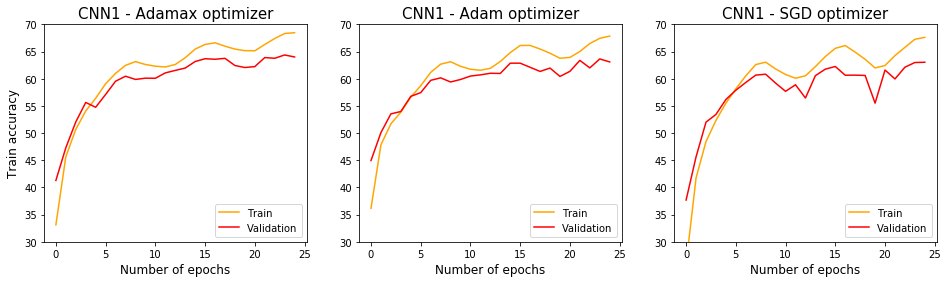

In [267]:
#compare generalization gap with Adam, Adamax and SGD optimizers run with CNN1, CLR method
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (16,4))
n = len(adamax_lrs[0])
ax1.plot(np.arange(0,n),adamax_lrs[0], label = 'Train', color = 'orange')
ax1.plot(np.arange(0,n), adamax_lrs[1], label = 'Validation', color = 'r')
ax1.set_ylim(30,70)
ax1.set_title('CNN1 - Adamax optimizer',fontsize=15)
ax1.set_ylabel('Train accuracy', fontsize = 12)
ax1.set_xlabel('Number of epochs', fontsize=12)
ax1.legend()
ax2.plot(np.arange(0,n),adam_lrs[0], label = 'Train', color = 'orange')
ax2.plot(np.arange(0,n), adam_lrs[1], label = 'Validation', color = 'r')
ax2.set_ylim(30,70)
ax2.set_xlabel('Number of epochs',fontsize=12)
ax2.set_title('CNN1 - Adam optimizer',fontsize=15)
ax2.legend()
ax3.plot(np.arange(0,n),sgd_lrs[0], label = 'Train', color = 'orange')
ax3.plot(np.arange(0,n), sgd_lrs[1], label = 'Validation', color = 'r')
ax3.set_ylim(30,70)
ax3.set_title('CNN1 - SGD optimizer',fontsize=15)
ax3.set_xlabel('Number of epochs',fontsize=12)
ax3.legend()


    

In [297]:
optimizers_list = [sgd_lrs,adam_lrs,adagrad_lrs,adamax_lrs,adadelta_lrs]
lrs_performances = [x[0] for x in optimizers_list]


Text(0.5, 1.0, 'Comparison of learning rates: SGD')

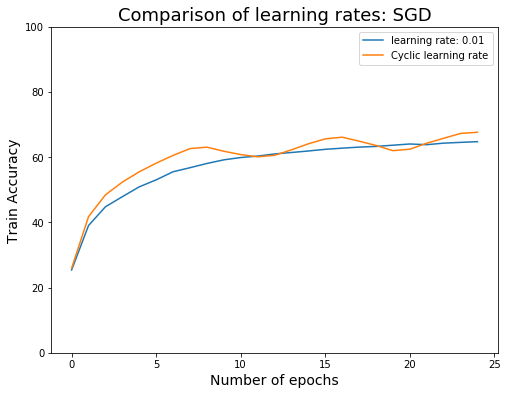

In [246]:
#comparisong SGD optimizer with default learning rate and CLR method scheduling
plt.figure(figsize=(8,6))
n = len(adamax_lrs[0])
plt.plot(np.arange(0,n),default_performances[0][0], label = 'learning rate: 0.01')
plt.plot(np.arange(0,n),sgd_lrs[0], label = 'Cyclic learning rate')
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Train Accuracy',fontsize=14)
plt.ylim(0,100)
plt.legend()
plt.title('Comparison of learning rates: SGD', fontsize=18)



In [110]:
#define class for CNN2 architecture
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3),
            #nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
          
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            #nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.fc_layers = nn.Sequential(
            nn.Linear(1024,120),
            #nn.Dropout(0.1),
            nn.Linear(120,84),
            #nn.Dropout(0.1),
            nn.Linear(84,10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out



In [ ]:
#LR range test for adamax optimizer with Model2
lr_range_finder(Model2(),'Adamax',start_lr=1e-7,end_lr=1e-1, lr_find_epochs=2, ax=None)

[1,   100] train loss: 2.199 , accuracy: 19.9%
[1,   200] train loss: 1.947 , accuracy: 28.6%
[1,   300] train loss: 1.842 , accuracy: 33.1%
[1,   400] train loss: 1.776 , accuracy: 35.2%
[1,   500] train loss: 1.739 , accuracy: 37.6%
[1,   600] train loss: 1.680 , accuracy: 38.8%
[1,   700] train loss: 1.641 , accuracy: 40.6%
[1,   800] train loss: 1.620 , accuracy: 41.5%
[1,   100] validation loss: 1.580 , accuracy: 41.8%
[1,   200] validation loss: 1.588 , accuracy: 42.4%
[2,   100] train loss: 1.562 , accuracy: 42.9%
[2,   200] train loss: 1.513 , accuracy: 43.8%
[2,   300] train loss: 1.506 , accuracy: 45.6%
[2,   400] train loss: 1.486 , accuracy: 45.9%
[2,   500] train loss: 1.451 , accuracy: 47.0%
[2,   600] train loss: 1.458 , accuracy: 46.7%
[2,   700] train loss: 1.432 , accuracy: 48.4%
[2,   800] train loss: 1.426 , accuracy: 49.0%
[2,   100] validation loss: 1.377 , accuracy: 50.8%
[2,   200] validation loss: 1.412 , accuracy: 50.1%
[3,   100] train loss: 1.396 , accuracy:

[18,   100] train loss: 0.562 , accuracy: 80.3%
[18,   200] train loss: 0.593 , accuracy: 79.1%
[18,   300] train loss: 0.593 , accuracy: 79.2%
[18,   400] train loss: 0.599 , accuracy: 78.4%
[18,   500] train loss: 0.623 , accuracy: 78.6%
[18,   600] train loss: 0.635 , accuracy: 78.0%
[18,   700] train loss: 0.636 , accuracy: 77.5%
[18,   800] train loss: 0.641 , accuracy: 77.5%
[18,   100] validation loss: 1.021 , accuracy: 67.5%
[18,   200] validation loss: 1.015 , accuracy: 67.9%
[19,   100] train loss: 0.596 , accuracy: 79.9%
[19,   200] train loss: 0.598 , accuracy: 79.0%
[19,   300] train loss: 0.622 , accuracy: 78.2%
[19,   400] train loss: 0.629 , accuracy: 77.9%
[19,   500] train loss: 0.652 , accuracy: 77.2%
[19,   600] train loss: 0.647 , accuracy: 77.2%
[19,   700] train loss: 0.655 , accuracy: 76.6%
[19,   800] train loss: 0.682 , accuracy: 76.1%
[19,   100] validation loss: 1.009 , accuracy: 66.6%
[19,   200] validation loss: 1.022 , accuracy: 67.3%
[20,   100] train lo

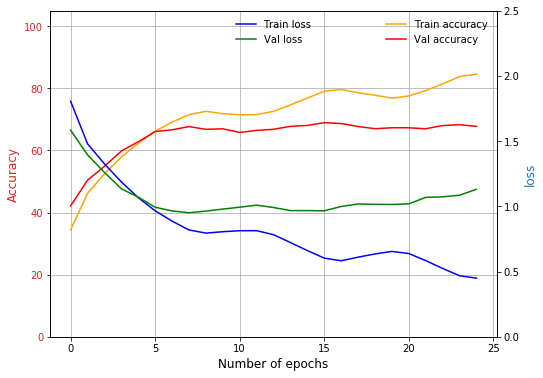

In [112]:
#run CNN2 with Adamax optimizer, CLR method scheduling for 25 epochs
adamax_lrs_2 = train_model_lrs(Model2(), 'Adamax', n_epochs=25,lr_max=2e-3, plot_history=True,print_stats=True)

Text(0.5, 1.0, 'Comparison of Neural network architectures')

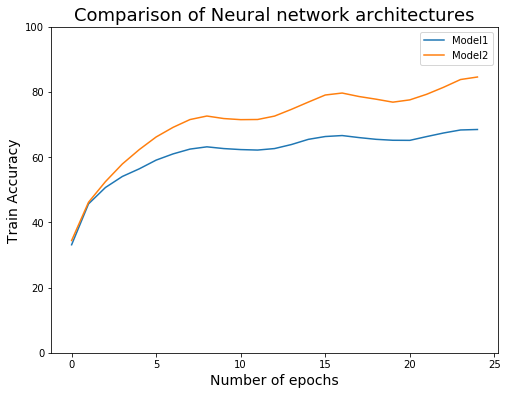

In [122]:
#compare training accuracy of CNN1 and CNN2
plt.figure(figsize=(8,6))
n = len(adamax_lrs[0])
plt.plot(np.arange(0,n),adamax_lrs[0], label = 'Model1')
plt.plot(np.arange(0,n),adamax_lrs_2[0], label = 'Model2')
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Train Accuracy',fontsize=14)
plt.ylim(0,100)
plt.legend()
plt.title('Comparison of Neural network architectures', fontsize=18)



In [144]:
#define class for CNN3
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
          
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.fc_layers = nn.Sequential(
            nn.Linear(1024,120),
            nn.BatchNorm1d(120),
            #nn.Dropout(0.1),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            #nn.Dropout(0.1),
            nn.Linear(84,10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [186]:
#augment images in train set
trainloader_ag,validloader = get_train_valid_loader(batch_size=50,
                           augment=True,
                           data_dir = './data',
                           random_seed=42,
                           valid_size=0.2,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False)
dataloaders = {'train': trainloader_ag, 'validation':validloader}

Files already downloaded and verified
Files already downloaded and verified


[1,   100] train loss: 2.205 , accuracy: 16.7%
[1,   200] train loss: 2.057 , accuracy: 24.8%
[1,   300] train loss: 1.962 , accuracy: 28.8%
[1,   400] train loss: 1.900 , accuracy: 30.4%
[1,   500] train loss: 1.839 , accuracy: 33.2%
[1,   600] train loss: 1.763 , accuracy: 35.3%
[1,   700] train loss: 1.732 , accuracy: 36.0%
[1,   800] train loss: 1.726 , accuracy: 36.1%
[1,   100] validation loss: 1.591 , accuracy: 41.1%
[1,   200] validation loss: 1.630 , accuracy: 40.1%
[2,   100] train loss: 1.686 , accuracy: 37.8%
[2,   200] train loss: 1.637 , accuracy: 39.2%
[2,   300] train loss: 1.656 , accuracy: 39.0%
[2,   400] train loss: 1.615 , accuracy: 39.9%
[2,   500] train loss: 1.581 , accuracy: 41.4%
[2,   600] train loss: 1.571 , accuracy: 42.5%
[2,   700] train loss: 1.591 , accuracy: 42.0%
[2,   800] train loss: 1.560 , accuracy: 42.8%
[2,   100] validation loss: 1.425 , accuracy: 48.6%
[2,   200] validation loss: 1.430 , accuracy: 47.4%
[3,   100] train loss: 1.551 , accuracy:

[18,   100] train loss: 0.943 , accuracy: 67.2%
[18,   200] train loss: 0.940 , accuracy: 66.9%
[18,   300] train loss: 0.953 , accuracy: 66.9%
[18,   400] train loss: 0.939 , accuracy: 66.5%
[18,   500] train loss: 0.964 , accuracy: 66.3%
[18,   600] train loss: 0.985 , accuracy: 65.2%
[18,   700] train loss: 1.003 , accuracy: 64.5%
[18,   800] train loss: 0.952 , accuracy: 67.0%
[18,   100] validation loss: 0.917 , accuracy: 68.2%
[18,   200] validation loss: 0.874 , accuracy: 69.6%
[19,   100] train loss: 0.966 , accuracy: 65.3%
[19,   200] train loss: 0.965 , accuracy: 65.8%
[19,   300] train loss: 0.972 , accuracy: 66.1%
[19,   400] train loss: 0.969 , accuracy: 66.3%
[19,   500] train loss: 1.008 , accuracy: 64.8%
[19,   600] train loss: 0.984 , accuracy: 66.1%
[19,   700] train loss: 0.966 , accuracy: 66.4%
[19,   800] train loss: 0.962 , accuracy: 65.9%
[19,   100] validation loss: 0.936 , accuracy: 68.1%
[19,   200] validation loss: 0.937 , accuracy: 67.8%
[20,   100] train lo

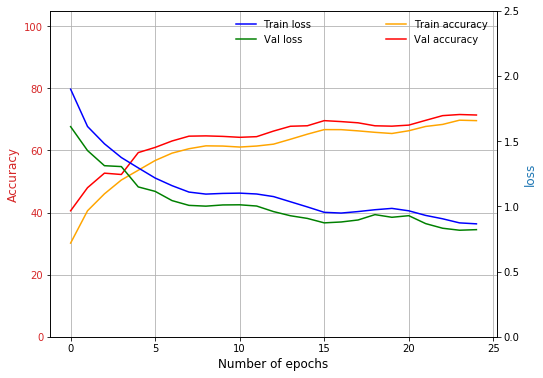

In [198]:
#Train model with CNN2 + image augmentation, Adamax optimizer, CLR method scheduling, for 25 epochs
adamax_lrs_2_ag = train_model_lrs(Model2(), 'Adamax', n_epochs=25,lr_max=2e-3, plot_history=True,print_stats=True, path = 'adamax_lrs_2_ag')

Text(0.5, 0, 'Number of epochs')

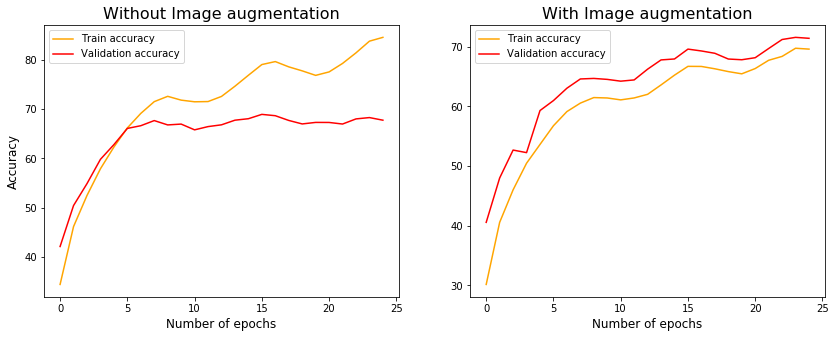

In [271]:
#compare generalization gap with and without augmenting images in train set, usinng CNN2
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
n = len(adamax_lrs_2[0])
ax1.plot(np.arange(0,n), adamax_lrs_2[0], color = 'orange', label='Train accuracy')
ax1.plot(np.arange(0,n), adamax_lrs_2[1], color = 'r', label='Validation accuracy')
ax1.set_title('Without Image augmentation', fontsize=16)
ax1.set_xlabel('Number of epochs',fontsize=12)
ax1.set_ylabel('Accuracy',fontsize=12)
ax1.legend()
ax2.plot(np.arange(0,n), adamax_lrs_2_ag[0], color = 'orange', label='Train accuracy')
ax2.plot(np.arange(0,n), adamax_lrs_2_ag[1], color = 'r', label='Validation accuracy')
ax2.legend()
ax2.set_title('With Image augmentation', fontsize=16)
ax2.set_xlabel('Number of epochs', fontsize=12)



[1,   100] train loss: 1.972 , accuracy: 28.0%
[1,   200] train loss: 1.781 , accuracy: 35.5%
[1,   300] train loss: 1.678 , accuracy: 39.5%
[1,   400] train loss: 1.637 , accuracy: 39.3%
[1,   500] train loss: 1.585 , accuracy: 43.3%
[1,   600] train loss: 1.513 , accuracy: 45.2%
[1,   700] train loss: 1.502 , accuracy: 45.7%
[1,   800] train loss: 1.505 , accuracy: 46.0%
[1,   100] validation loss: 1.362 , accuracy: 51.4%
[1,   200] validation loss: 1.337 , accuracy: 52.2%
[2,   100] train loss: 1.420 , accuracy: 49.3%
[2,   200] train loss: 1.441 , accuracy: 48.2%
[2,   300] train loss: 1.422 , accuracy: 48.8%
[2,   400] train loss: 1.410 , accuracy: 49.1%
[2,   500] train loss: 1.375 , accuracy: 51.4%
[2,   600] train loss: 1.340 , accuracy: 51.9%
[2,   700] train loss: 1.350 , accuracy: 51.6%
[2,   800] train loss: 1.328 , accuracy: 52.3%
[2,   100] validation loss: 1.200 , accuracy: 57.0%
[2,   200] validation loss: 1.212 , accuracy: 56.2%
[3,   100] train loss: 1.321 , accuracy:

[18,   100] train loss: 0.870 , accuracy: 69.6%
[18,   200] train loss: 0.918 , accuracy: 68.5%
[18,   300] train loss: 0.907 , accuracy: 68.3%
[18,   400] train loss: 0.886 , accuracy: 68.3%
[18,   500] train loss: 0.890 , accuracy: 68.8%
[18,   600] train loss: 0.900 , accuracy: 69.0%
[18,   700] train loss: 0.884 , accuracy: 68.7%
[18,   800] train loss: 0.876 , accuracy: 69.8%
[18,   100] validation loss: 0.820 , accuracy: 71.7%
[18,   200] validation loss: 0.791 , accuracy: 72.4%
[19,   100] train loss: 0.884 , accuracy: 69.5%
[19,   200] train loss: 0.905 , accuracy: 68.9%
[19,   300] train loss: 0.890 , accuracy: 68.8%
[19,   400] train loss: 0.927 , accuracy: 67.4%
[19,   500] train loss: 0.914 , accuracy: 68.5%
[19,   600] train loss: 0.923 , accuracy: 68.3%
[19,   700] train loss: 0.916 , accuracy: 67.5%
[19,   800] train loss: 0.916 , accuracy: 68.2%
[19,   100] validation loss: 0.808 , accuracy: 72.3%
[19,   200] validation loss: 0.830 , accuracy: 70.7%
[20,   100] train lo

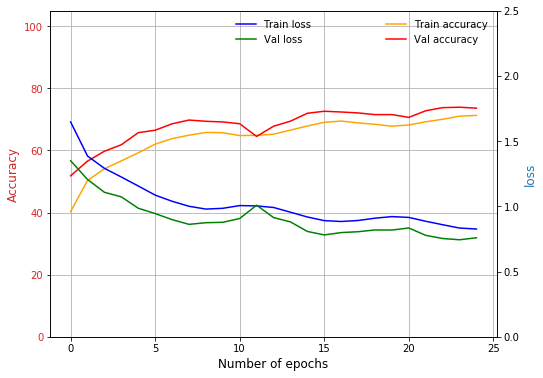

In [217]:
#Train model with CNN3 + image augmentation + CLR scheduling, for 25 epochs
adamax_lrs_3_ag_25epochs = train_model_lrs(Model3(), 'Adamax', n_epochs=25,lr_max=2e-3, plot_history=True,print_stats=True, path = 'adamax_lrs_3_ag_25epochs')

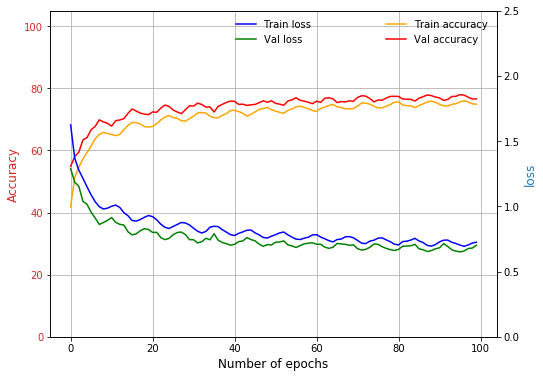

In [155]:
#Train model with CNN3 + image augmentation + CLR scheduling, for 100 epochs
adamax_lrs_2_BND_ag = train_model_lrs(Model3(), 'Adamax', n_epochs=100,lr_max=2e-3,path='adamax_lrs_2_BND_ag.pth', plot_history=True,print_stats=False)

In [162]:
#define function to evalute dataset for classification accuracy
def model_eval(testloader,model,weights_path):
    net = model
    net.load_state_dict(torch.load(weights_path)) 
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100*correct/total

    return accuracy

In [190]:
#define class for CNN4
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
          
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        nn.MaxPool2d(2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.fc_layers = nn.Sequential(
            nn.Linear(2304,1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024,256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256,10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

[1,   100] train loss: 1.904 , accuracy: 30.7%
[1,   200] train loss: 1.646 , accuracy: 39.1%
[1,   300] train loss: 1.571 , accuracy: 44.4%
[1,   400] train loss: 1.481 , accuracy: 45.5%
[1,   500] train loss: 1.391 , accuracy: 49.8%
[1,   600] train loss: 1.348 , accuracy: 50.8%
[1,   700] train loss: 1.307 , accuracy: 54.1%
[1,   800] train loss: 1.303 , accuracy: 52.6%
[1,   100] validation loss: 1.126 , accuracy: 59.5%
[1,   200] validation loss: 1.135 , accuracy: 59.5%
[2,   100] train loss: 1.201 , accuracy: 57.1%
[2,   200] train loss: 1.209 , accuracy: 57.4%
[2,   300] train loss: 1.175 , accuracy: 58.2%
[2,   400] train loss: 1.143 , accuracy: 59.2%
[2,   500] train loss: 1.128 , accuracy: 60.7%
[2,   600] train loss: 1.077 , accuracy: 61.7%
[2,   700] train loss: 1.043 , accuracy: 63.4%
[2,   800] train loss: 1.055 , accuracy: 63.3%
[2,   100] validation loss: 0.978 , accuracy: 64.9%
[2,   200] validation loss: 0.979 , accuracy: 64.9%
[3,   100] train loss: 1.001 , accuracy:

[18,   100] train loss: 0.479 , accuracy: 83.5%
[18,   200] train loss: 0.445 , accuracy: 84.3%
[18,   300] train loss: 0.455 , accuracy: 84.7%
[18,   400] train loss: 0.483 , accuracy: 83.6%
[18,   500] train loss: 0.459 , accuracy: 84.5%
[18,   600] train loss: 0.430 , accuracy: 84.7%
[18,   700] train loss: 0.478 , accuracy: 83.6%
[18,   800] train loss: 0.447 , accuracy: 84.0%
[18,   100] validation loss: 0.532 , accuracy: 81.7%
[18,   200] validation loss: 0.521 , accuracy: 82.5%
[19,   100] train loss: 0.440 , accuracy: 84.6%
[19,   200] train loss: 0.455 , accuracy: 84.0%
[19,   300] train loss: 0.451 , accuracy: 84.1%
[19,   400] train loss: 0.418 , accuracy: 85.3%
[19,   500] train loss: 0.446 , accuracy: 84.6%
[19,   600] train loss: 0.448 , accuracy: 84.2%
[19,   700] train loss: 0.468 , accuracy: 83.7%
[19,   800] train loss: 0.449 , accuracy: 85.3%
[19,   100] validation loss: 0.487 , accuracy: 83.7%
[19,   200] validation loss: 0.453 , accuracy: 84.3%
[20,   100] train lo

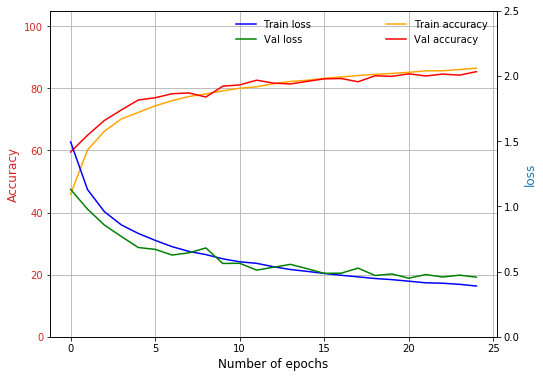

In [194]:
#Train model with CNN4 + image augmentation, Adamax optimizer, default learning rate, for 25 epochs
adamax_def_4 = train_model(Model4(), 'Adamax', n_epochs=25, plot_history=True,print_stats=True)

[1,   100] train loss: 1.928 , accuracy: 30.9%
[1,   200] train loss: 1.702 , accuracy: 37.5%
[1,   300] train loss: 1.582 , accuracy: 42.5%
[1,   400] train loss: 1.531 , accuracy: 45.1%
[1,   500] train loss: 1.457 , accuracy: 46.8%
[1,   600] train loss: 1.429 , accuracy: 49.0%
[1,   700] train loss: 1.416 , accuracy: 48.5%
[1,   800] train loss: 1.337 , accuracy: 51.9%
[1,   100] validation loss: 1.246 , accuracy: 55.0%
[1,   200] validation loss: 1.222 , accuracy: 55.9%
[2,   100] train loss: 1.313 , accuracy: 52.3%
[2,   200] train loss: 1.288 , accuracy: 53.9%
[2,   300] train loss: 1.263 , accuracy: 55.0%
[2,   400] train loss: 1.258 , accuracy: 55.4%
[2,   500] train loss: 1.238 , accuracy: 56.3%
[2,   600] train loss: 1.208 , accuracy: 57.4%
[2,   700] train loss: 1.191 , accuracy: 57.4%
[2,   800] train loss: 1.193 , accuracy: 57.3%
[2,   100] validation loss: 1.058 , accuracy: 62.2%
[2,   200] validation loss: 1.077 , accuracy: 62.1%
[3,   100] train loss: 1.151 , accuracy:

[18,   100] train loss: 0.468 , accuracy: 84.1%
[18,   200] train loss: 0.464 , accuracy: 83.6%
[18,   300] train loss: 0.463 , accuracy: 83.7%
[18,   400] train loss: 0.478 , accuracy: 83.4%
[18,   500] train loss: 0.456 , accuracy: 84.3%
[18,   600] train loss: 0.482 , accuracy: 83.4%
[18,   700] train loss: 0.481 , accuracy: 82.9%
[18,   800] train loss: 0.509 , accuracy: 81.8%
[18,   100] validation loss: 0.534 , accuracy: 82.2%
[18,   200] validation loss: 0.523 , accuracy: 82.5%
[19,   100] train loss: 0.471 , accuracy: 83.9%
[19,   200] train loss: 0.492 , accuracy: 82.9%
[19,   300] train loss: 0.512 , accuracy: 82.3%
[19,   400] train loss: 0.490 , accuracy: 83.3%
[19,   500] train loss: 0.510 , accuracy: 82.2%
[19,   600] train loss: 0.488 , accuracy: 83.1%
[19,   700] train loss: 0.550 , accuracy: 81.1%
[19,   800] train loss: 0.550 , accuracy: 80.9%
[19,   100] validation loss: 0.519 , accuracy: 82.2%
[19,   200] validation loss: 0.544 , accuracy: 81.6%
[20,   100] train lo

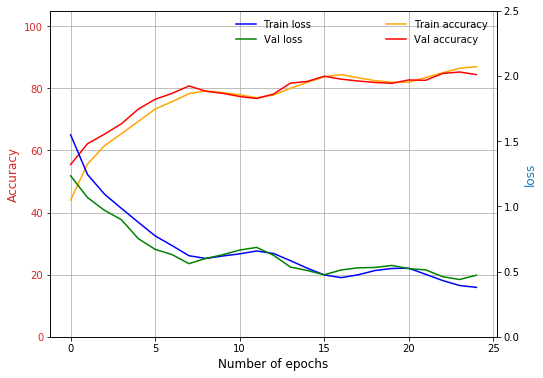

In [195]:
#Train model with CNN4 + image augmentation, Adamax optimizer, CLR method scheduling, for 25 epochs
adamax_lrs_4 = train_model_lrs(Model4(), 'Adamax', n_epochs=25,lr_max=2e-3,path='adamax_lrs_4.pth', plot_history=True,print_stats=True)


Text(0.5, 1.0, 'Effect of Batch Normalization')

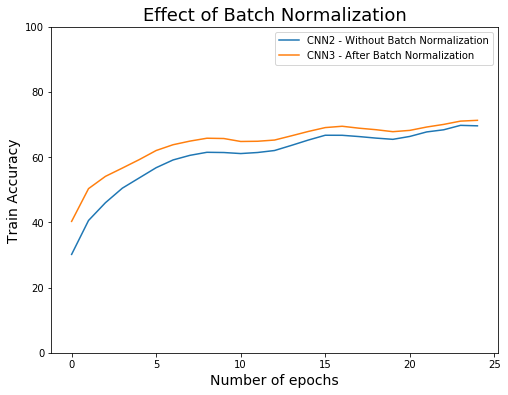

In [273]:
plt.figure(figsize=(8,6))
n = len(adamax_lrs_2_ag[0])
plt.plot(np.arange(0,n),adamax_lrs_2_ag[0], label = 'CNN2 - Without Batch Normalization')
plt.plot(np.arange(0,n),adamax_lrs_3_ag_25epochs[0], label = 'CNN3 - After Batch Normalization')
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Train Accuracy',fontsize=14)
plt.ylim(0,100)
plt.legend()
plt.title('Effect of Batch Normalization', fontsize=18)

[1,   100] train loss: 2.226 , accuracy: 16.6%
[1,   200] train loss: 2.045 , accuracy: 25.8%
[1,   300] train loss: 1.978 , accuracy: 29.0%
[1,   400] train loss: 1.912 , accuracy: 30.7%
[1,   500] train loss: 1.853 , accuracy: 32.4%
[1,   600] train loss: 1.831 , accuracy: 32.1%
[1,   700] train loss: 1.771 , accuracy: 35.1%
[1,   800] train loss: 1.771 , accuracy: 35.6%
[1,   100] validation loss: 1.660 , accuracy: 39.8%
[1,   200] validation loss: 1.685 , accuracy: 38.0%
[2,   100] train loss: 1.736 , accuracy: 37.0%
[2,   200] train loss: 1.708 , accuracy: 37.4%
[2,   300] train loss: 1.697 , accuracy: 37.3%
[2,   400] train loss: 1.666 , accuracy: 38.1%
[2,   500] train loss: 1.653 , accuracy: 39.4%
[2,   600] train loss: 1.660 , accuracy: 40.1%
[2,   700] train loss: 1.645 , accuracy: 39.9%
[2,   800] train loss: 1.599 , accuracy: 41.6%
[2,   100] validation loss: 1.546 , accuracy: 42.3%
[2,   200] validation loss: 1.541 , accuracy: 43.6%
[3,   100] train loss: 1.589 , accuracy:

[18,   100] train loss: 1.209 , accuracy: 57.9%
[18,   200] train loss: 1.173 , accuracy: 59.5%
[18,   300] train loss: 1.201 , accuracy: 57.2%
[18,   400] train loss: 1.174 , accuracy: 58.6%
[18,   500] train loss: 1.208 , accuracy: 57.4%
[18,   600] train loss: 1.199 , accuracy: 58.0%
[18,   700] train loss: 1.207 , accuracy: 57.6%
[18,   800] train loss: 1.208 , accuracy: 57.4%
[18,   100] validation loss: 1.071 , accuracy: 62.1%
[18,   200] validation loss: 1.091 , accuracy: 61.3%
[19,   100] train loss: 1.195 , accuracy: 58.1%
[19,   200] train loss: 1.206 , accuracy: 57.7%
[19,   300] train loss: 1.197 , accuracy: 57.5%
[19,   400] train loss: 1.221 , accuracy: 56.7%
[19,   500] train loss: 1.196 , accuracy: 58.1%
[19,   600] train loss: 1.221 , accuracy: 56.8%
[19,   700] train loss: 1.213 , accuracy: 57.8%
[19,   800] train loss: 1.223 , accuracy: 57.3%
[19,   100] validation loss: 1.089 , accuracy: 61.8%
[19,   200] validation loss: 1.091 , accuracy: 61.7%
[20,   100] train lo

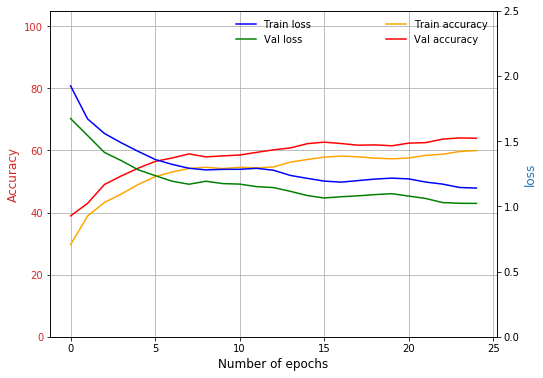

In [222]:
##Train model with CNN1 + image augmentation + CLR scheduling, for 25 epochs (for fair comparison of all network architectures)
adamax_lrs_1_ag = train_model_lrs(Model1(), 'Adamax', n_epochs=25,lr_max=2e-3, plot_history=True,print_stats=True, path = 'adamax_lrs_1_ag_25epochs')

Text(0.5, 1.0, 'Comparison of Network Architectures')

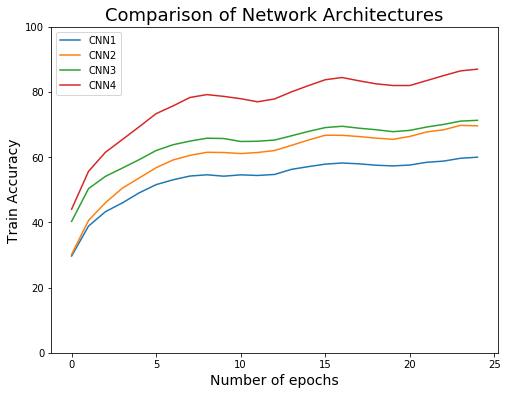

In [260]:
#Compare all network architectures by training models with Adamax optimizer + CLR + image augmentation, for 25 epochs 
plt.figure(figsize=(8,6))
n = len(adamax_lrs_1_ag[0])
plt.plot(np.arange(0,n),adamax_lrs_1_ag[0], label = 'CNN1')
plt.plot(np.arange(0,n),adamax_lrs_2_ag[0], label = 'CNN2')
plt.plot(np.arange(0,n),adamax_lrs_3_ag_25epochs[0], label = 'CNN3')
plt.plot(np.arange(0,n),adamax_lrs_4[0], label = 'CNN4')
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Train Accuracy',fontsize=14)
plt.ylim(0,100)
plt.legend()
plt.title('Comparison of Network Architectures', fontsize=18)

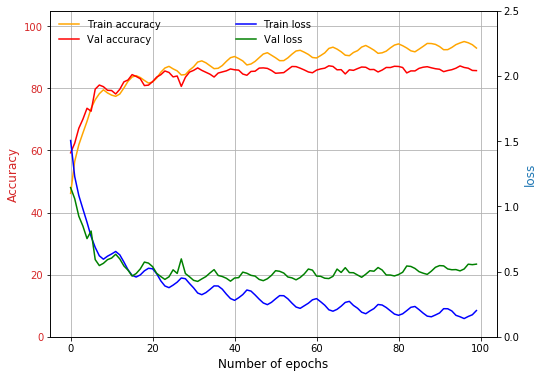

In [224]:
#Train model with CNN4 + image augmentation + Adamax+ CLR scheduling, for 100 epochs
adamax_lrs_4_ag100epochs = train_model_lrs(Model4(), 'Adamax', n_epochs=100,lr_max=2e-3,path='adamax_lrs_4_ag100epochs.pth', plot_history=True,print_stats=False)

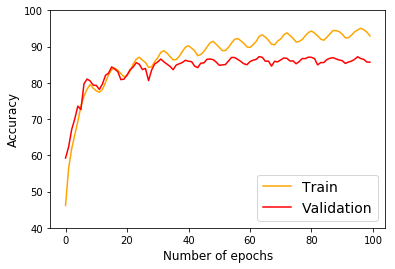

In [296]:
#plot train and validation accuracy curves of final model (for report)
n = len(adamax_lrs_4_ag100epochs[0])
plt.plot(np.arange(0,n),adamax_lrs_4_ag100epochs[0], label = 'Train', color = 'orange')
plt.plot(np.arange(0,n), adamax_lrs_4_ag100epochs[1], label = 'Validation', color = 'r')
plt.ylim(40,100)
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Number of epochs', fontsize=12)
plt.legend(fontsize=14)

In [298]:
#evaluate model4 on validation set
val_accuracy = model_eval(validloader,Model4(),'adamax_lrs_4_ag100epochs.pth')
print('Accuracy with CNN4 network on validation data is {}'.format(val_accuracy))

Accuracy with CNN4 network on validation data is 83.76


In [299]:
#evaluate model4 on test set
test_accuracy = model_eval(testloader,Model4(),'adamax_lrs_4_ag100epochs.pth')
print('Accuracy with CNN4 network on test data is {}'.format(test_accuracy))

Accuracy with CNN4 network on test data is 83.1


In [275]:
!pip install torchsummary

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [278]:
from torchsummary import summary
summary(Model1(), input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Total Size (MB): 0.36
---------------------------------------------

In [279]:
summary(Model2(), input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
              ReLU-2            [-1, 8, 30, 30]               0
         MaxPool2d-3            [-1, 8, 15, 15]               0
            Conv2d-4           [-1, 32, 13, 13]           2,336
              ReLU-5           [-1, 32, 13, 13]               0
         MaxPool2d-6             [-1, 32, 6, 6]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
              ReLU-8             [-1, 64, 4, 4]               0
            Linear-9                  [-1, 120]         123,000
           Linear-10                   [-1, 84]          10,164
           Linear-11                   [-1, 10]             850
Total params: 155,070
Trainable params: 155,070
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [280]:
summary(Model3(), input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
       BatchNorm2d-2            [-1, 8, 30, 30]              16
              ReLU-3            [-1, 8, 30, 30]               0
         MaxPool2d-4            [-1, 8, 15, 15]               0
            Conv2d-5           [-1, 32, 13, 13]           2,336
       BatchNorm2d-6           [-1, 32, 13, 13]              64
              ReLU-7           [-1, 32, 13, 13]               0
         MaxPool2d-8             [-1, 32, 6, 6]               0
            Conv2d-9             [-1, 64, 4, 4]          18,496
      BatchNorm2d-10             [-1, 64, 4, 4]             128
             ReLU-11             [-1, 64, 4, 4]               0
           Linear-12                  [-1, 120]         123,000
      BatchNorm1d-13                  [-1, 120]             240
           Linear-14                   

In [281]:
summary(Model4(), input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
       BatchNorm2d-2            [-1, 8, 30, 30]              16
              ReLU-3            [-1, 8, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           2,336
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 12, 12]          18,496
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
           Conv2d-11          [-1, 128, 10, 10]          73,856
      BatchNorm2d-12          [-1, 128, 10, 10]             256
             ReLU-13          [-1, 128, 10, 10]               0
        MaxPool2d-14            [-1, 12